In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

TensorFlow 2.x selected.


# Data

In [0]:
# Dataset
N = 100
D = 1  # input dimension
K = 1  # output dimension
X = np.random.random((N, D)) * 2 - 1  # between (-1, 1)
w = np.random.randn(D, K)  # parameters we want to predict
b = np.random.randn(K)  # parameters we want to predict
# Cast float64 to float32
w = w.astype(np.float32)
b = b.astype(np.float32)
X = X.astype(np.float32)
# Targets
Y = X.dot(w) + b + 0.1 * np.random.randn(N, 1)  # with noise

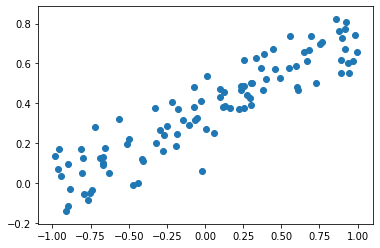

In [0]:
plt.scatter(X,Y)
plt.show()

# Custom Layer and Model (low-level, without keras)

In [0]:
class LinearRegression:
  def __init__(self, units=1):
    self.built = False
    self.trainable_weights = []
    self.units = units
  
  def __call__(self, inputs):
    if not self.built: self.build(inputs.shape)
    return self.call(inputs)

  # We creare weights lazily when the input value becomes known.
  def build(self, input_shape):
    self.w = tf.Variable(tf.random_normal_initializer()((input_shape[-1], self.units)))
    self.b = tf.Variable(tf.zeros(self.units))
    self.trainable_weights = [self.w, self.b]
    self.built = True

  # Forward step
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

  # Convert tensor to numpy array
  def predict(self, inputs):
    return self.__call__(inputs).numpy()

In [0]:
lr = LinearRegression()

# Directly after layer initialization, there are no weights, yet.
print("Weights directly after initialization:", lr.trainable_weights)

lr(X[0:1])

# After build() method is called, weights are initialized.
# Note that there is also the trainable_weights attribute, that is the right one to access at training time.
# For this simple model, all weights are trainable.
print("Weights after first call:", lr.trainable_weights)

Weights directly after initialization: []
Weights after first call: [<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.02195994]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [0]:
# Note the difference between __call__() and predict()
print("__call__ :", lr(X[0:1]))
print("predict  :", lr.predict(X[0:1]))

__call__ : tf.Tensor([[-0.00371635]], shape=(1, 1), dtype=float32)
predict  : [[-0.00371635]]


## Low-level training loop with with GradientTape

Since our model does not inherit from keras.Model, we cannot use keras' methods compile() and fit(). We need to write our training loop explicitly. We use GradientTape to compute grandients, and the optimizer's apply_gradients() method to do one step of gradient descent.

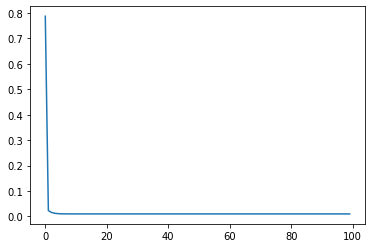

In [0]:
model = LinearRegression()

# We could use tf.keras.losses.MeanSquaredError()
def loss_fn(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

EPOCHS = 100
losses = []
for epoch in range(EPOCHS):
  # Get gradients
  with tf.GradientTape() as tape:
    loss = loss_fn(Y, model(X))
  grads = tape.gradient(loss, model.trainable_weights)

  # Do one step of backpropagation via gradient descent
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # Store loss
  losses.append(loss)

plt.plot(losses)
plt.show()

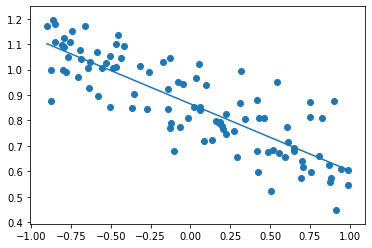

In [0]:
# Check the regression line visually
x_axis = np.linspace(X.min(), X.max(), 100).astype(np.float32)
y_axis = model.predict(x_axis.reshape(-1, 1)).flatten()

plt.scatter(X, Y)
plt.plot(x_axis, y_axis)
plt.show()

In [0]:
print("Predicted params:")
print([w.numpy() for w in model.trainable_weights])
print("True params:")
print([w, b])

Predicted params:
[array([[-0.26249847]], dtype=float32), array([0.86518574], dtype=float32)]
True params:
[array([[-0.25638986]], dtype=float32), array([0.8858937], dtype=float32)]


# Custom Layer and Model with Keras

We subclass keras.layers.Layer and keras.Model, as described in:

https://www.tensorflow.org/guide/keras/custom_layers_and_models

These classes comes with convenient attributes, such has Layer.weights, Layer.trainable_weights, Model.layers, Model.weights, Model.trainable_weights. They all get populated automatically by the Layer's and Model's \_\_call\_\_ method.

The main Layer's methods to override are \_\_init\_\_, and build() and call(), both called by \_\_call\_\_. \_\_init\_\_ is meant to store the model's hyperparameters, but not to initialize weights. Weights should be initialised when the input is passed to the layer for the first time via \_\_call\_\_. If the layer has not been built,\_\_call\_\_ calls automatically the build() method, with argument input_shape. In the build() method, we can use the Layer.add_weight() method to create new weights. Finally, call() is meant to implement the layer'sforward pass. 

The main Model's methods to override are \_\_init\_\_ and call(). \_\_init\_\_ must contain all model's layers, assigned to attributes. call() implements the model's forward pass, using the layers defined in \_\_init\_\_. Note that the model populates attributes such as Model.layers and Model.weights by accumulating its layers's attributes, but only for the layers defined in \_\_init\_\_. Any layer defined in the call() method and not in \_\_init\_\_ is not seen by standard Keras functions. For example, it and its weights does not appear in the summary() method. Finally, the predict() method does not need to be overriden. predict() calls \_\_call\_\_ and then converts the output tensors into numpy arrays.


In [0]:
class Linear(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__(**kwargs)
    self.units = units
  
  def build(self, input_shape):
    #self.w = tf.Variable(tf.random_normal_initializer()((input_shape[-1], self.units)))
    #self.b = tf.Variable(tf.zeros(self.units))
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer=tf.initializers.RandomNormal,
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer=tf.initializers.Zeros,
                             trainable=True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


class LinearRegression(tf.keras.Model):
  def __init__(self, units=1, **kwargs):
    super().__init__(**kwargs)
    self.linear_layer = Linear(units)
  
  # Forward step
  def call(self, inputs):
    return self.linear_layer(inputs)

In [0]:
lr = LinearRegression()
print("Model layers:", lr.layers, end='\n\n')

# Each layer has property weights inherited from class Layer, giving all layer's parameters.
# We can access all layers' parameters from the modle property weights, inherited from class Model.
# Directly after layer initialization, there are no weights, yet.
assert lr.weights == lr.linear_layer.weights
print("Weights directly after initialization:", lr.weights, end='\n\n')

lr(X[0:1])

# After build() method is called, weights are initialized.
# Note that there is also the trainable_weights attribute, that is the right one to access at training time.
# For this simple model, all weights are trainable.
assert lr.weights == [lr.linear_layer.w, lr.linear_layer.b]
assert lr.trainable_weights == lr.weights
print("Weights after first call:", lr.weights, end='\n\n')
# Model's method summary can be used, but only after the model has been built
lr.summary()

Model layers: [<__main__.Linear object at 0x7f1548773e48>]

Weights directly after initialization: []

Weights after first call: [<tf.Variable 'linear_regression_12/linear_13/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.06526373]], dtype=float32)>, <tf.Variable 'linear_regression_12/linear_13/Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

Model: "linear_regression_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_13 (Linear)           multiple                  2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Note the difference between __call__ and predict()
print("__call__ :", lr(X[0:1]))
print("predict  :", lr.predict(X[0:1]))

__call__ : tf.Tensor([[-0.00846482]], shape=(1, 1), dtype=float32)
predict  : [[-0.00846482]]


## Train using the inherited keras.Model's methods compile() and fit()

In [0]:
model = LinearRegression()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2),
              loss=tf.keras.losses.MeanSquaredError())

r = model.fit(X, Y, epochs=20)

Train on 100 samples
Epoch 1/20
100/100 [==============================] - 0s 3ms/sample - loss: 0.1161
Epoch 2/20
100/100 [==============================] - 0s 104us/sample - loss: 0.0242
Epoch 3/20
100/100 [==============================] - 0s 95us/sample - loss: 0.0132
Epoch 4/20
100/100 [==============================] - 0s 85us/sample - loss: 0.0113
Epoch 5/20
100/100 [==============================] - 0s 83us/sample - loss: 0.0108
Epoch 6/20
100/100 [==============================] - 0s 82us/sample - loss: 0.0099
Epoch 7/20
100/100 [==============================] - 0s 83us/sample - loss: 0.0104
Epoch 8/20
100/100 [==============================] - 0s 80us/sample - loss: 0.0099
Epoch 9/20
100/100 [==============================] - 0s 82us/sample - loss: 0.0099
Epoch 10/20
100/100 [==============================] - 0s 80us/sample - loss: 0.0098
Epoch 11/20
100/100 [==============================] - 0s 82us/sample - loss: 0.0098
Epoch 12/20
100/100 [==============================] 

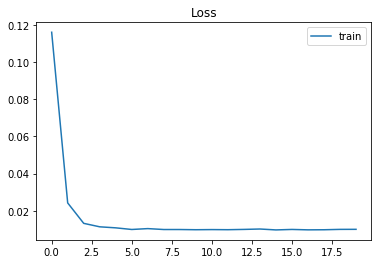

In [0]:
plt.plot(r.history['loss'], label='train')
plt.title('Loss')
plt.legend()
plt.show()

In [0]:
print("Predicted params:")
print([w.numpy() for w in model.trainable_weights])
print("True params:")
print([w, b])

Predicted params:
[array([[0.3735144]], dtype=float32), array([0.36135352], dtype=float32)]
True params:
[array([[0.3771766]], dtype=float32), array([0.35822618], dtype=float32)]


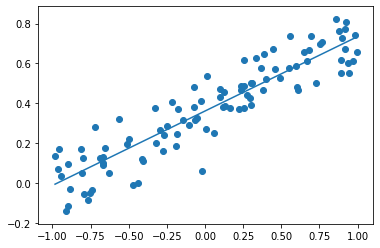

In [0]:
# Check the regression line visually
x_axis = np.linspace(X.min(), X.max(), 100).astype(np.float32)
y_axis = model.predict(x_axis.reshape(-1, 1)).flatten()

plt.scatter(X, Y)
plt.plot(x_axis, y_axis)
plt.show()

## Low-level training loop with with GradientTape

Below we train the model explicitly, using GradientTape to calculate gradients, and the optimizer's apply_gradients() method to do one step of gradient descent.

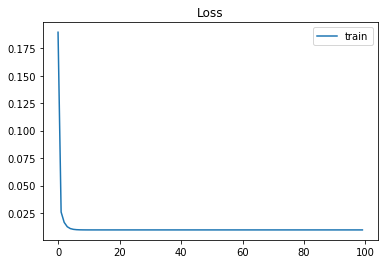

In [0]:
model = LinearRegression()

# We could use tf.keras.losses.MeanSquaredError()
def loss_fn(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

# We do not rewrite the optimizer from scratch
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

EPOCHS = 20
losses = []
for epoch in range(EPOCHS):
  # Get gradients
  with tf.GradientTape() as tape:
    loss = loss_fn(Y, model(X))
  grads = tape.gradient(loss, model.trainable_weights)

  # Do one step of backpropagation via gradient descent
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # Store loss
  losses.append(loss)

plt.plot(losses, label='train')
plt.title('Loss')
plt.legend()
plt.show()

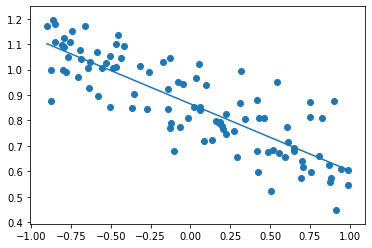

In [0]:
# Check the regression line visually
x_axis = np.linspace(X.min(), X.max(), 100).astype(np.float32)
y_axis = model.predict(x_axis.reshape(-1, 1)).flatten()

plt.scatter(X, Y)
plt.plot(x_axis, y_axis)
plt.show()

In [0]:
print("Predicted params:")
print([w.numpy() for w in model.trainable_weights])
print("True params:")
print([w, b])

Predicted params:
[array([[-0.26249847]], dtype=float32), array([0.86518574], dtype=float32)]
True params:
[array([[-0.25638986]], dtype=float32), array([0.8858937], dtype=float32)]
